In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.nn.utils import clip_grad_norm_

from time import time
import numpy as np
import pandas as pd

# from model import EncoderBahdanau, AttentionBahdanau, DecoderBahdanau, Seq2SeqBahdanau
import torch
import torch.nn as nn
from torch import optim
from torch.nn.utils import clip_grad_norm_

from time import time
import numpy as np
import pandas as pd

# from model import *
from base import *


In [2]:
def to_tensor(arr_list, device):
    tensor_list = []
    for arr in arr_list:
        tensor_list.append(torch.tensor(arr, device=device, dtype=torch.float))
    return tensor_list


def train_epoch(model, input_seq_len, output_seq_len, batch_size, optimizer, criterion, clip, device):
    # no need to use it here since there's no dropout or batchnorm
    model.train()

    epoch_loss, iterations = 0, 0
    for inputs, outputs, targets, start_points in generate_samples(Xtrain, ytrain, batch_size,
                                                                   input_seq_len, output_seq_len):
        optimizer.zero_grad()
        inputs, outputs, targets = to_tensor([inputs, outputs, targets], device)
#         import pdb; pdb.set_trace()
        outputs = model(inputs, outputs, teacher_forcing_ratio=0.3)
        if len(outputs) == 2:
            outputs = outputs[0]
#         import pdb; pdb.set_trace()
        loss = criterion(outputs.view(-1), targets.view(-1))
        loss.backward()
        clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        iterations += 1

    # average batch loss
    # return epoch_loss / iterations

    # mse (set reduction to sum)
    total_num = output_seq_len * (len(Xtrain) - input_seq_len - output_seq_len + 1)
    return epoch_loss / total_num

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def init_weights(m):
    for name, param in m.named_parameters():
        if len(param.data.size()) == 1:
            nn.init.normal_(param.data, 0, 1)
        else:
            nn.init.xavier_uniform_(param.data)


def set_seed():
    SEED = 12
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True



In [ ]:
class EncoderBahdanau(nn.Module):
    def __init__(self, inputs_size, encoder_hidden_size, decoder_hidden_size):
        super(EncoderBahdanau, self).__init__()
        self.gru = nn.GRU(inputs_size, encoder_hidden_size, bidirectional=True)
        self.linear = nn.Linear(encoder_hidden_size * 2, decoder_hidden_size)

    def forward(self, inputs):
        # inputs: (sequence, batch, feature)
        # outputs: (sequence, batch, hidden * direction)
        # hidden: (layer * direction, batch, hidden)

        # hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        # outputs are always from the last layer

        outputs, hidden = self.gru(inputs) # hidden:torch.Size([2, 256, 64]) INPUT_SEQ_LEN= 30; 256 = batch_size;  hidden_size =128
        hidden = torch.tanh(self.linear(torch.cat((hidden[::2, :, :], hidden[1::2, :, :]), dim=2)))
        return outputs, hidden  ### Output: torch.Size([30, 256, 128]); hidden: torch.Size([1, 256, 128])


class AttentionBahdanau(nn.Module):
    def __init__(self, encoder_hidden_size, decoder_hidden_size):
        super(AttentionBahdanau, self).__init__()
        self.attn = nn.Linear(encoder_hidden_size * 2 + decoder_hidden_size, decoder_hidden_size)
        self.v = nn.Parameter(torch.rand(decoder_hidden_size), requires_grad=True)  # size = [128]


    def forward(self, decoder_hidden, encoder_outputs):
        # encoder outputs: (encoder_sequence, batch, encoder_hidden * direction)
        # decoder hidden: (layer, batch, decoder_hidden)
        # attention: (batch, encoder_sequence)
        encoder_seq_len, batch_size, _ = encoder_outputs.size() ##  encoder_outputs : torch.Size([30, 256, 128])
        decoder_hidden = decoder_hidden.repeat(encoder_seq_len, 1, 1) ## decoder_hidden : torch.Size([1, 256, 64]) 每次传一个time_step --> decoder_hidden :torch.Size([30, 256, 64])
        # pass encoder outputs and previous decoder hidden through a multi-layer perceptron, this is called an alignment model
        # e(i, j) = a(s(i-1), h(j))
        # energy scores how well  the inputs around position j and the outputs around position i match
        energy = torch.tanh(self.attn(torch.cat([encoder_outputs, decoder_hidden], dim=2))) ### energy : torch.Size([30, 256, 128])
        # bmm requires batch first
        energy = energy.permute(1, 2, 0)   ###[256, 128,30]  (batch, hidden, tiem_step)
        v = self.v.repeat(batch_size, 1).unsqueeze(1) ## torch.Size([256, 1, 128])
        attention = torch.softmax(torch.bmm(v, energy).squeeze(1), dim=1) #[256, 1, 128] * [256, 128,30] = [256, 1, 30].squeeze(1) = [256,30]
        # soft_max(dim=0)对列进行softmax; dim=1为 行。 对每一个batch样本中，不同的time_step进行softmax。
        return attention


class DecoderBahdanau(nn.Module):
    def __init__(self, inputs_size, encoder_hidden_size, decoder_hidden_size, attention):
        super(DecoderBahdanau, self).__init__()
        self.gru = nn.GRU(inputs_size + encoder_hidden_size * 2, decoder_hidden_size)    
        ### decoder_input: (time_step, batch, features)(1, batch_size, inputs_size + encoder_hidden_size * 2)     [1, 256, 128] --> [1, 256, 128]
        self.attention = attention  ### [256, 30]
        self.linear = nn.Linear(encoder_hidden_size * 2 + decoder_hidden_size + inputs_size, 1)  ### [128 + 128 + 30, 1]

    def forward(self, inputs, decoder_hidden, encoder_outputs):
        # inputs: (1, batch, feature)
        # decoder hidden: (1, batch, decoder_hidden)
        # encoder outputs: (sequence, batch, encoder_hidden * direction)
        attn_weights = self.attention(decoder_hidden, encoder_outputs)   ### [256,30]
        # bmm requires batch first
        attn_weights = attn_weights.unsqueeze(1)  ### [256,1,30]
        encoder_outputs = encoder_outputs.permute(1, 0, 2) ### torch.Size([256, 30, 128])
        import pdb; pdb.set_trace()        
        attn_weighted = torch.bmm(attn_weights, encoder_outputs).permute(1, 0, 2) ###  [256,1,30]*([256, 30, 128])= [256,1,128].permute = [1,256,128] 
        output, hidden = self.gru(torch.cat([inputs, attn_weighted], dim=2), decoder_hidden) ### torch.Size([1, 256, 24]) + [1,256,128] = [1, 256, 128+24]
        ### hidden: [1,256,128+24] --> [1,256,128], output: [1, 256, 128]
        output = self.linear(torch.cat([inputs.squeeze(0), attn_weighted.squeeze(0), output.squeeze(0)], dim=1))


        return hidden, output, attn_weights.squeeze(1)


class Seq2SeqBahdanau(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqBahdanau, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, inputs, outputs, mean_, std_, teacher_forcing_ratio=0.5):
        # inputs: (input_sequence, batch, feature)
        # outputs: (output_sequence, batch, feature)
        # targets: (output_sequence, batch, 1)
        input_sequence_size = inputs.size(0)
        output_sequence_size, batch_size, feature_size = outputs.size()
        encoder_outputs, encoder_hidden = self.encoder(inputs)

        decoder_input = torch.cat([inputs[-1:][:, :, :1], outputs[:1][:, :, 1:]], dim=2)   
        ### inputs最后一个label,outputs所有的features
        decoder_hidden = encoder_hidden ## encoder的最后一个h
        decoder_outputs = torch.zeros(output_sequence_size, batch_size, 1).to(self.device)  ###生成所有output为0
        attentions = torch.zeros(output_sequence_size, batch_size, input_sequence_size).to(self.device)
        #### 初始化attentions [1,256,1] 
        for i in range(output_sequence_size):
            decoder_hidden, decoder_output, attention = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_outputs[i] = decoder_output
            attentions[i] = attention

            if i == output_sequence_size - 1:
                break

            if np.random.random() < teacher_forcing_ratio:
                decoder_input = torch.cat([outputs[i:i+1][:, :, :1], outputs[i+1:i+2][:, :, 1:]], dim=2)
            else:
                # no teacher forcing
                decoder_output = (decoder_output - mean_) / std_
                decoder_input = torch.cat([decoder_output.unsqueeze(0), outputs[i+1:i+2][:, :, 1:]], dim=2)
        return decoder_outputs, attentions
    
    
    
    

In [3]:
class Encoder(nn.Module):
    def __init__(self, FEATURE_SIZE, ENCODER_HIDDEN_SIZE, DECODER_HIDDEN_SIZE):
        super(Encoder, self).__init__()
        self.gru = nn.GRU(FEATURE_SIZE, ENCODER_HIDDEN_SIZE, 1, bidirectional=True)
                           # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
 
        self.linear = nn.Linear(ENCODER_HIDDEN_SIZE*2, DECODER_HIDDEN_SIZE)
        ### 将encoder_hidden_size转化为decoder_hidden_size
    def forward(self, encoder_inputs):
        encoder_hideen_outputs, hidden = self.gru(encoder_inputs) ##encoder_hidden_size*2
        decoder_hidden = torch.tanh(self.linear(torch.cat([hidden[::2,:,:],hidden[1::2,:,:]],dim=2)))
        return encoder_hideen_outputs, decoder_hidden
        
class Attention(nn.Module):
    def __init__(self, ENCODER_HIDDEN_SIZE, DECODER_HIDDEN_SIZE):
        super(Attention, self).__init__()
        self.attn = nn.Linear(ENCODER_HIDDEN_SIZE*2 + DECODER_HIDDEN_SIZE, DECODER_HIDDEN_SIZE)
        self.v = nn.Parameter(torch.rand(DECODER_HIDDEN_SIZE), requires_grad = True)  # [10]
    def forward(self, encoder_hidden_outputs, decoder_hidden):
        encoder_time_step, batch_size, _ = encoder_hidden_outputs.size()
        decoder_hidden_repeat = decoder_hidden.repeat(encoder_time_step, 1,1)
        # encoder_hidden_outputs: [30, 256, DEcoder_hidden_size]
        # decoder_hidden_repeat: [30, 256, DEcoder_hidden_size]
        energy = torch.tanh(self.attn(torch.cat([encoder_hidden_outputs, decoder_hidden_repeat],dim=2)))  
        # [encoder_time_step, batch, encoder_hidden*2] + [encoder_time_step, batch, decoder_hidden]
        # self.v [decoder_hidden]
        v = self.v.repeat(batch_size,1).unsqueeze(1)    ###[batch_size,1,decoder_hidden_size]
        attention = torch.softmax(torch.bmm(v,energy.permute(1,2,0)).squeeze(1),dim=1) ### 
         ###[batch_size,1,decoder_hidden_size] * [batch_size, decoder_hidden, encoder_time_step] =[batch,1,encoder_time_step] -->[batch,encoder_time_step]
        return attention

class Decoder(nn.Module):
    def __init__(self, INPUT_SIZE,ENCODER_HIDDEN_SIZE, DECODER_HIDDEN_SIZE, attention):
        super(Decoder, self).__init__()
        self.gru = nn.GRU(ENCODER_HIDDEN_SIZE*2 + INPUT_SIZE, DECODER_HIDDEN_SIZE)  ### 必须给decoder_hidden_size
        self.attention = attention
        self.linear = nn.Linear(INPUT_SIZE + ENCODER_HIDDEN_SIZE*2 + DECODER_HIDDEN_SIZE,1)
    def forward(self,inputs ,encoder_hidden_outputs, decoder_hidden):
        attn_weights = self.attention(encoder_hidden_outputs, decoder_hidden).unsqueeze(1) ### [batch,1, encoder_time_step]
        encoder_hidden_outputs = encoder_hidden_outputs.permute(1, 0, 2) ### encoder_hidden_outputs: [time_step, batch, encoder_hidden_size*2].permute
        attn_weighted = torch.bmm(attn_weights, encoder_hidden_outputs).permute(1, 0, 2)  
        ### [batch,1, encoder_time_step]*[batch,encoder_time_step, encoder_hidden_size*2] =[batch, 1, encoder_hidden_size*2]
        output, hidden = self.gru(torch.cat([inputs, attn_weighted], dim=2),decoder_hidden)     ###[ 1, 256, 24] ,   attn_weighted = [256,1,64*2]
        ###此处不传decoder_hidden, 则默认decoder_hidden=0
        output = self.linear(torch.cat([inputs.squeeze(0), attn_weighted.squeeze(0), output.squeeze(0)], dim=1))  
        ### inputs: [time=1, batch, features], attn_weighted: [batch, 1, encoder_hidden_size*2], output: [time, batch, decoder_hidden]
        return hidden, output, attn_weights.squeeze(1)
        
        
class Seq2Seq(nn.Module):
    def __init__(self, encoder,decoder, teacher_forcing_ratio = 0.5):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder    
    def forward(self,inputs_batch, outputs_batch, teacher_forcing_ratio):
        encoder_hidden_outputs, encoder_hidden = self.encoder(inputs_batch)

        decoder_time_step, batch_size, decoder_feature_size = outputs_batch.size()
        input_sequence_size = inputs_batch.size(0)
        decoder_hidden = encoder_hidden
        decoder_inputs = torch.cat([inputs_batch[-1:][:,:,:1], outputs_batch[:1][:,:,1:]],dim=2)  ###需要保持维度：所以要用[-1:]
        decoder_outputs = torch.zeros(decoder_time_step, batch_size, 1)
        attentions = torch.zeros(decoder_time_step,batch_size, input_sequence_size)
        for i in range(decoder_time_step):
            decoder_hidden, decoder_output, attention = self.decoder(decoder_inputs, encoder_hidden_outputs, decoder_hidden)    
            decoder_outputs[i] = decoder_output
            attentions[i] = attention
            if i == decoder_time_step - 1:
                break
            if np.random.random()< teacher_forcing_ratio:
                decoder_inputs = torch.cat([outputs_batch[i:i+1][:,:,:1], outputs_batch[i+1:i+2][:,:,1:]],dim=2)
            else:
                decoder_inputs = torch.cat([decoder_output.unsqueeze(0), outputs_batch[i+1:i+2][:,:,1:]], dim=2)
#         import pdb; pdb.set_trace()        
        return decoder_outputs, attentions   


In [4]:
#   decoder_inputs.size()
# torch.Size([1, 256, 24])
# (Pdb)  encoder_hidden_outputs.size()
# torch.Size([30, 256, 128])
# (Pdb)  decoder_hidden.size()
# torch.Size([1, 256, 10])

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.xls')

data = create_features(data)
# pm2.5列必须放在第一个
FEATURE_COLS = ['pm2.5', 'year', 'TEMP']
DATE_COLS = ['sin_week', 'cos_week', 'sin_hour', 'cos_hour', 'month_2', 'month_3', 'month_4', 'month_5',
             'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
             'month_12', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
             'weekday_5', 'weekday_6']
Xtrain, ytrain, Xtest, ytest, mean_, std_ = preprocessing(data, FEATURE_COLS, DATE_COLS)


FEATURE_SIZE = len(FEATURE_COLS) + len(DATE_COLS)
ENCODER_HIDDEN_SIZE = 64
DECODER_HIDDEN_SIZE = 10
LAYER_NUM = 2
ENCODER_DROPOUT = 0.5
DECODER_DROPOUT = 0.5
encoder = Encoder(FEATURE_SIZE, ENCODER_HIDDEN_SIZE, DECODER_HIDDEN_SIZE)
attn = Attention(ENCODER_HIDDEN_SIZE, DECODER_HIDDEN_SIZE)
decoder = Decoder(FEATURE_SIZE, ENCODER_HIDDEN_SIZE, DECODER_HIDDEN_SIZE, attn)
seq2seq = Seq2Seq(encoder, decoder)

In [7]:
seq2seq.apply(init_weights)

optimizer = optim.SGD(seq2seq.parameters(), lr=0.1, nesterov=True, momentum=0.9)
criterion = nn.MSELoss(reduction='sum')

INPUT_SEQ_LEN = 30
OUTPUT_SEQ_LEN = 14
BATCH_SIZE = 256
EPOCH_NUM = 10
CLIP = 1

min_val_loss = float('inf')

for epoch in range(EPOCH_NUM):

    start_time = time()

    train_loss = train_epoch(seq2seq, INPUT_SEQ_LEN, OUTPUT_SEQ_LEN,
                             BATCH_SIZE, optimizer, criterion, CLIP, device)

    set_seed()
#     val_loss = evaluate(seq2seq, INPUT_SEQ_LEN, OUTPUT_SEQ_LEN,
#                         BATCH_SIZE, criterion, device)

    end_time = time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print('Epoch: %s | Time: %sm %ss' % (str(epoch+1).zfill(2), epoch_mins, epoch_secs))
    print('\tTrain Loss: %.3f' % (train_loss))

Epoch: 01 | Time: 1m 41s
	Train Loss: 1.345
Epoch: 02 | Time: 1m 40s
	Train Loss: 0.574
Epoch: 03 | Time: 1m 41s
	Train Loss: 0.501
Epoch: 04 | Time: 1m 39s
	Train Loss: 0.478
Epoch: 05 | Time: 1m 39s
	Train Loss: 0.470


KeyboardInterrupt: 

In [14]:
def return_pred_target(model, input_seq_len, output_seq_len, batch_size, criterion, device):
    # no need to use it here since there's no dropout or batchnorm
    model.eval()

    epoch_loss, iterations = 0, 0
    with torch.no_grad():
        start_points_length = Xtest.shape[0] - input_seq_len - output_seq_len + 1
        outputs_mat = torch.zeros(start_points_length, output_seq_len)
        targets_mat = torch.zeros(start_points_length, output_seq_len)
        attentions_mat = torch.zeros(start_points_length, output_seq_len, input_seq_len)
        start_points_mat = torch.zeros(start_points_length, 1)
        for inputs, outputs, targets, start_points in generate_samples(Xtest, ytest, batch_size,
                                                                       input_seq_len, output_seq_len):
            inputs, outputs, targets, start_points = to_tensor([inputs, outputs, targets, start_points], device)
            # turn off teacher forcing
            outputs, attentions = model(inputs, outputs, teacher_forcing_ratio=0)
            outputs_mat[iterations*batch_size:(iterations+1)*batch_size] = torch.expm1(outputs[:, :, 0]).transpose(0, 1)
            targets_mat[iterations*batch_size:(iterations+1)*batch_size] = torch.expm1(targets[:, :, 0]).transpose(0, 1)
            attentions_mat[iterations*batch_size:(iterations+1)*batch_size] = attentions.permute(1, 0, 2)
            start_points_mat[iterations*batch_size:(iterations+1)*batch_size] = start_points.view(-1, 1)
            iterations += 1

    return outputs_mat.numpy(), targets_mat.numpy(), attentions_mat.numpy(), start_points_mat

In [16]:
l1, l2, l3, l4 =return_pred_target(seq2seq, INPUT_SEQ_LEN, OUTPUT_SEQ_LEN, BATCH_SIZE, criterion, device)

In [23]:
d1 = pd.DataFrame(l1, columns=['l1','l2','l3','l4', 'l5', 'l6','l7','l8','l9','l10', 'l11', 'l12','l13', 'l14'])
d2 = pd.DataFrame(l2, columns=['l1','l2','l3','l4', 'l5', 'l6','l7','l8','l9','l10', 'l11', 'l12','l13', 'l14'])

In [25]:
import matplotlib.pyplot as plot

In [41]:
d11 = pd.DataFrame(d1.apply(lambda x: np.sum(x),axis=0).values,columns=['prediction']).reset_index().rename(columns={'index': 'home'})
d12 = pd.DataFrame(d2.apply(lambda x: np.sum(x),axis=0).values,columns=['real']).reset_index().rename(columns={'index': 'home'})

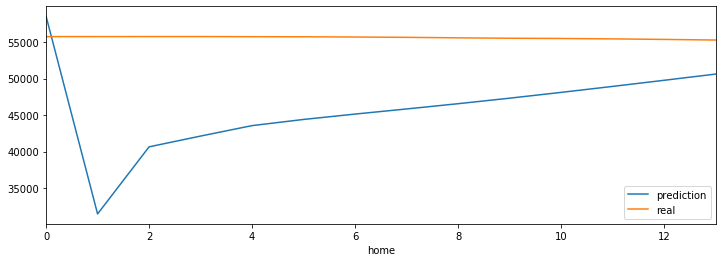

In [43]:
ax = d11.plot(x='home',y='prediction', figsize=(12,4),legend='initial')
d12.plot(x='home',y='real',figsize=(12,4),ax=ax,legend='after distinct')

In [ ]:
ax = tt.plot(x='dt',y='forecast_x', figsize=(12,4),legend='initial')
tt.plot(x='dt',y='forecast_y',figsize=(12,4),ax=ax,legend='after distinct')

In [ ]:
def evaluate(model, input_seq_len, output_seq_len, batch_size, criterion, device):
    # no need to use it here since there's no dropout or batchnorm
    model.eval()

    epoch_loss, iterations = 0, 0
    with torch.no_grad():
        for inputs, outputs, targets in generate_samples(Xtest, ytest, batch_size,
                                                         input_seq_len, output_seq_len):
            inputs, outputs, targets = to_tensor([inputs, outputs, targets], device)
            # turn off teacher forcing
            outputs = model(inputs, outputs, teacher_forcing_ratio=0)
            loss = criterion(outputs.view(-1), targets.view(-1))
            epoch_loss += loss
            iterations += 1

    # return epoch_loss / iterations
    total_num = output_seq_len * (len(Xtest) - input_seq_len - output_seq_len + 1)
    return epoch_loss / total_num
